In [1]:
import os
import gin
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader
from dynamics.quadrotors import Quadrotors2D
from configs.dynamics.dynamics_config import Quadrotors2DConfig

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

2023-12-31 15:12:34.480040: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

Define Dynamics

In [ ]:
path_to_dynamics_config_file = os.path.normpath(
    os.path.join(
        os.path.dirname(os.path.abspath("")),
        "configs/dynamics/quadrotors2D.gin",
        )
    )
gin.parse_config_file(path_to_dynamics_config_file)
dynamics_config = Quadrotors2DConfig()
dynamics = Quadrotors2D(dynamics_config)
dt = dynamics_config.dt


In [ ]:
maximum_rollout_step = 200
xf = np.array([0,0,0,0,0,0])
uf = np.array([4.905, 4.905])
obs_min = np.array([-2,-2,-1.5,-5,-5,-2])
obs_max = np.array([2,2,1.5,5,5,2])

Q = np.eye(6)
R = np.eye(2)
R_inv = np.linalg.inv(R)

A = np.vstack([np.hstack([np.zeros((3,3)), np.eye(3)]),
                np.array([0,0,-dynamics.g, 0,0,0]),
                np.zeros((2,6))
                ])

B = np.vstack([np.zeros((4,2)),
                np.ones((1,2)) / dynamics.m,
                np.array([dynamics.r/dynamics.I, -dynamics.r/dynamics.I])])

P = scipy.linalg.solve_continuous_are(A, B, Q, R)
K = np.dot(R_inv, np.dot(B.T, P))

Define architectures

In [ ]:
class PDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = dynamics.states_wrap(x - xf)
        y = nn.Dense(128, use_bias=False)(x)
        y = nn.relu(y)
        y = nn.Dense(128, use_bias=False)(y)
        y = nn.relu(y)
        y = nn.Dense(64, use_bias=False)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()
    
class SoftPDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = dynamics.states_wrap(x - xf)
        y = nn.Dense(128)(x)
        y = nn.relu(y)
        y = nn.Dense(128)(y)
        y = nn.relu(y)
        y = nn.Dense(64)(y)
        y = nn.Dense(1)(y)

        return y.squeeze()

Define dataset

In [ ]:
class StateDataset(Dataset):
    def __init__(self, xs):
        super().__init__()
        self.xs = xs
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, index):
        return self.xs[index]

In [ ]:
def running_cost(x, u):
    x_diff = dynamics.states_wrap(x - xf)
    u_diff = u - uf
    return x_diff.T @ Q @ x_diff + u_diff.T @ R @ u_diff

def rollout_trajectory(get_control_efforts):
    trajectory = []
    cumulated_cost = 0
    x = dynamics.get_initial_state()
    within_range = True
    
    for i in range(maximum_rollout_step):
        
        if within_range:
            if np.any(dynamics.states_wrap(x - xf) > obs_max) or \
                np.any(dynamics.states_wrap(x - xf) < obs_min):
                within_range = False
            else:
                trajectory.append(x)

                u = get_control_efforts(x) 
                x = dynamics.simulate(x,u)
                cumulated_cost += dt * running_cost(x, u)

    return trajectory, cumulated_cost

In [ ]:
dataset = StateDataset([xf]*256)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=True)
pd_value_function_approximator = PDValueApproximator()
key, key_to_use = jax.random.split(key)
pd_model_variables = pd_value_function_approximator.init(key_to_use, jnp.zeros((1,6)))
pd_model_states, pd_model_params = pd_model_variables.pop('params')
del pd_model_variables
pd_optimizer = optax.adam(learning_rate=1e-3)
pd_optimizer_states = pd_optimizer.init(pd_model_params)

pd_cumulated_cost_during_learning_mean = []
pd_cumulated_cost_during_learning_std = []

def get_pd_control(x):
    u, v_gradient, updated_states = get_pd_control_with_additional_term(pd_model_params, pd_model_states, x)
    return np.asarray(u)

@jax.jit
def get_pd_control_with_additional_term(params, states, x):
    v_gradient, updated_states = get_pd_v_gradient(params, states, x)
    f_1, f_2 = dynamics.get_control_affine_matrix(x)
    # For the case when R is identity, the optimal u solve minimize the QP is by clipping
    u = jnp.clip(-R_inv @ f_2.T @ v_gradient / 2 + uf, dynamics.umin, dynamics.umax)
    return u, v_gradient, updated_states

@jax.jit
def get_pd_v_gradient(params, states, x):
    return jax.grad(pd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))

def pd_hjb_loss(params, states, xs):
    def loss(x):
        f_1, f_2 = dynamics.get_control_affine_matrix(x)
        u, v_gradient, updated_states = get_pd_control_with_additional_term(params, states, x)
        x_dot = f_1 + f_2 @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot / (running_cost(x, u) + 1e-10) + 1)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def pd_params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(pd_hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = pd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

pd_losses = []

for epoch in range(200):
    
    cumulated_cost_list = []
    trajectory_length = 0
    for _ in range(20):
        trajectory, cumulated_cost = rollout_trajectory(get_pd_control)
        trajectory_length += len(trajectory)
        cumulated_cost_list.append(cumulated_cost)
        dataset.xs.extend(trajectory)
    cumulated_cost_list = np.array(cumulated_cost_list)
    pd_cumulated_cost_during_learning_mean.append(np.mean(cumulated_cost_list))
    pd_cumulated_cost_during_learning_std.append(np.std(cumulated_cost_list))

    pd_total_loss = 0
    for i, xs in enumerate(dataloader):
        pd_model_params, pd_model_states, pd_optimizer_states, pd_loss = pd_params_update(pd_model_params, pd_model_states, pd_optimizer_states, xs)
        pd_total_loss += pd_loss
    pd_losses.append(pd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{pd_total_loss / len(dataloader)}, cumulated cost:{np.mean(cumulated_cost_list)}, avg trajectory length: {trajectory_length / 20}")

pd_cumulated_cost_during_learning_mean = np.array(pd_cumulated_cost_during_learning_mean)
pd_cumulated_cost_during_learning_std = np.array(pd_cumulated_cost_during_learning_std)

epoch:10 loss:0.86580890417099, cumulated cost:16.194489330456726, avg trajectory length: 2.5
epoch:20 loss:0.4436933100223541, cumulated cost:39.00107130663527, avg trajectory length: 20.95
epoch:30 loss:0.3005389869213104, cumulated cost:20.84105693841946, avg trajectory length: 21.7
epoch:40 loss:0.20830154418945312, cumulated cost:13.18518135331264, avg trajectory length: 15.1
epoch:50 loss:0.19156520068645477, cumulated cost:10.498325215524217, avg trajectory length: 28.15
epoch:60 loss:0.0992812067270279, cumulated cost:6.685719280631756, avg trajectory length: 51.85
epoch:70 loss:0.08709388971328735, cumulated cost:5.20014190214001, avg trajectory length: 70.2
epoch:80 loss:0.050533100962638855, cumulated cost:4.242736495517358, avg trajectory length: 68.7
epoch:90 loss:0.04467681050300598, cumulated cost:6.623598501743052, avg trajectory length: 42.85
epoch:100 loss:0.03909352794289589, cumulated cost:2.945105631734542, avg trajectory length: 76.95
epoch:110 loss:0.033612880855

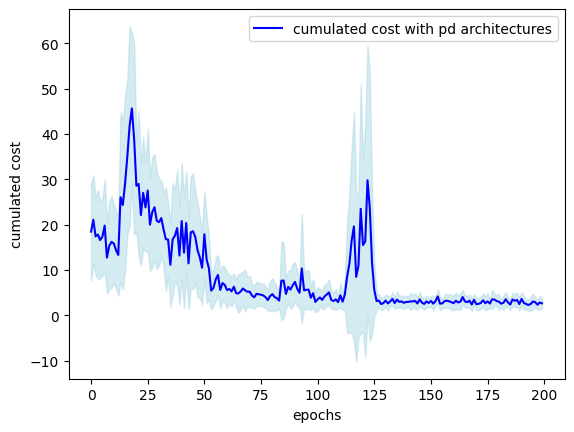

In [ ]:
plt.plot(pd_cumulated_cost_during_learning_mean, color="blue", label="cumulated cost with pd architectures")
plt.fill_between(range(len(pd_cumulated_cost_during_learning_mean)), 
                 pd_cumulated_cost_during_learning_mean+pd_cumulated_cost_during_learning_std, 
                 pd_cumulated_cost_during_learning_mean-pd_cumulated_cost_during_learning_std, color="lightblue", alpha=0.5)

plt.legend()
plt.xlabel("epochs")
plt.ylabel("cumulated cost")
plt.show()

Test policy

In [ ]:
def get_LQR_control(x):
     return np.clip(-K @ dynamics.states_wrap(x - xf) + uf, dynamics.umin, dynamics.umax)

def test_learned_policy(x0, T=10):
    ts = np.arange(0, T, dt)
    xs_pd = [x0]
    xs_lqr = [x0]
    us_pd = []
    us_lqr = []
    cost_pd = 0
    cost_lqr = 0

    for t in ts:
        us_pd.append(get_pd_control(xs_pd[-1]))
        cost_pd += running_cost(xs_pd[-1], us_pd[-1]) * dt
        xs_pd.append(dynamics.simulate(xs_pd[-1], us_pd[-1]))

        us_lqr.append(get_LQR_control(xs_lqr[-1]))
        cost_lqr += running_cost(xs_lqr[-1], us_lqr[-1]) * dt
        xs_lqr.append(dynamics.simulate(xs_lqr[-1], us_lqr[-1]))

    xs_pd = np.array(xs_pd)
    xs_lqr = np.array(xs_lqr)

    return ts, xs_pd, xs_lqr, cost_pd, cost_lqr
def visualize_traj(xs_pd, xs_lqr):
    r = 0.05
    plt.plot(xs_pd[:,0], xs_pd[:,1], '-b', label="pd trajectory")
    plt.plot([xs_pd[-1,0] - r * np.cos(xs_pd[-1,2]),
                xs_pd[-1,0] + r * np.cos(xs_pd[-1,2])],
            [xs_pd[-1,1] - r * np.sin(xs_pd[-1,2]),
                xs_pd[-1,1] + r * np.sin(xs_pd[-1,2])], '-b')
    plt.plot(xs_lqr[:,0], xs_lqr[:,1], '--r', label="lqr trajectory")
    plt.plot([xs_lqr[-1,0] - r * np.cos(xs_lqr[-1,2]),
                xs_lqr[-1,0] + r * np.cos(xs_lqr[-1,2])],
            [xs_lqr[-1,1] - r * np.sin(xs_lqr[-1,2]),
                xs_lqr[-1,1] + r * np.sin(xs_lqr[-1,2])], '--r')
    plt.plot(xf[0], xf[1], 'g*', label="desired position")
    plt.title("quadrotor 2D trajectory")
    plt.xlabel("x(meter)")
    plt.ylabel("y(meter)")
    plt.legend()

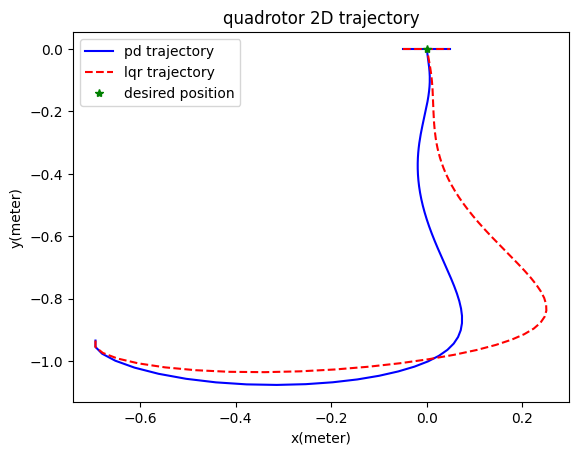

In [ ]:
x0 = dynamics.get_initial_state()
ts, xs_pd, xs_lqr, cost_pd, cost_lqr = test_learned_policy(x0)
visualize_traj(xs_pd, xs_lqr)

cost_pd_list = [cost_pd]
cost_lqr_list = [cost_lqr]
for i in range(1, 100):
    x0 = dynamics.get_initial_state()
    ts, xs_pd, xs_lqr, cost_pd, cost_lqr = test_learned_policy(x0)
    cost_pd_list.append(cost_pd)
    cost_lqr_list.append(cost_lqr)

cost_pd_list = np.array(cost_pd_list)
cost_lqr_list = np.array(cost_lqr_list)

In [ ]:
print("mean pd: ", np.mean(cost_pd_list))
print("mean lqr: ", np.mean(cost_lqr_list))

mean pd:  8.003131248310678
mean lqr:  8.540354249649736
